# TRANSFORMACIÓN DE DATOS

## IMPORTAR PAQUETES

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import Binarizer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import MinMaxScaler

#Automcompletar rápido
%config IPCompleter.greedy=True

## IMPORTAR LOS DATOS

1.- Sustituir la ruta del proyecto.

In [62]:
ruta_proyecto = 'C:/Users/Marius/EstructuraDirectorio/03_MACHINE_LEARNING/07_CASOS/03_RIESGOS'

2.- Nombrar los ficheros de datos.

In [63]:
nombre_cat = 'cat_resultado_eda.pickle'
nombre_num = 'num_resultado_eda.pickle'

3.- Cargar los datos.

In [64]:
cat = pd.read_pickle(ruta_proyecto + '/02_Datos/03_Trabajo/' + nombre_cat)
num = pd.read_pickle(ruta_proyecto + '/02_Datos/03_Trabajo/' + nombre_num)

Recordamos lo que habíamos identificado en fases anteriores y lo organizamos por tipo de acción.

Modificar con pandas/numpy:

* Crear la target a partir de estado
* Discretizar num_meses_desde_ult_retraso
* En vivienda juntar NONE y OTHER
* En finalidad juntar renewable_energy, educational y vacation en 'otros'

Modificar con scikit learn:

* La variable descripcion podríamos trabajarla con un TF-IDF Vectorizer
* Convertir num_derogatorios a binaria

## CREACIÓN DE VARIABLES Y TRANSFORMACIONES CON PANDAS

### Target para el modelo PD

PD es la probabilidad de cada cliente con un prestamo determinado,de que ese cliente genere un impago.Un impago seria el retraso en el pago de sus cuotas que se mantenga durante al menos 90 dias.

In [65]:
cat.estado.value_counts()

Fully Paid                                             66305
Current                                                54018
Charged Off                                            16447
Late (31-120 days)                                      1309
In Grace Period                                          538
Late (16-30 days)                                        270
Does not meet the credit policy. Status:Fully Paid       106
Does not meet the credit policy. Status:Charged Off       57
Default                                                    3
Name: estado, dtype: int64

Hay una categoria que se llama Late, en esta categoria tenemos clientes que estan entre 31-90 dias, que según nuestro criterio son clientes buenos, hasta que no superen los 90dias. Al ser una categoria mayoritaria de buenos,se la asignamos a la categoria de buenos, concientes de que estamos cometiendo un error.

Crear la target a partir de estado

In [66]:
# partir de la variable estado definimos quienes son los buenos y los malos
cat['target_pd'] = np.where(cat.estado.isin(['Charged Off','Does not meet the credit policy. Status:Charged Off','Default']), 1, 0)
cat

,empleo,antigüedad_empleo,ingresos_verificados,rating,vivienda,descripcion,finalidad,num_cuotas,estado,target_pd
id_cliente,,,,,,,,,,
137387967,Hvac technician,3 years,Source Verified,A,MORTGAGE,desconocido,debt_consolidation,36 months,Current,0
132883631,Subsea Technician,7 years,Source Verified,B,MORTGAGE,desconocido,debt_consolidation,36 months,Fully Paid,0
131289518,desconocido,10+ years,Source Verified,D,MORTGAGE,desconocido,home_improvement,60 months,Current,0
77861711,Correctional officer,10+ years,Verified,C,MORTGAGE,desconocido,debt_consolidation,36 months,Charged Off,1
103448519,Web site administrator,10+ years,Not Verified,A,MORTGAGE,desconocido,credit_card,36 months,Current,0
...,...,...,...,...,...,...,...,...,...,...
73222117,Executive Assistant,10+ years,Verified,B,RENT,desconocido,debt_consolidation,36 months,Fully Paid,0
129396054,Field Manager,10+ years,Source Verified,D,OWN,desconocido,debt_consolidation,60 months,Current,0
121031962,Owner & President,6 years,Verified,B,MORTGAGE,desconocido,other,36 months,Current,0


In [67]:
#Eliminamos ya que actua directamente sobre la target.
cat.drop(columns='estado',inplace=True)

### Target para el modelo EAD

EAD: EXPOSURE AT DEFAULT: Es cuanto debe todavia el cliente de su prestamo en el momento en el que se produce el impago.Cliente pide 30k ha amortizado 10k y cuando se produce el impago todavia debe 20k.

Definimos una variable pendiente que es lo que falta por pagar.

Será el porcentaje del principal que no había sido amortizado.

Por tanto: pendiente / principal

Primero tenemos que construir el pendiente como el principal menos el amortizado.

In [68]:
num['pendiente'] = num.principal - num.imp_amortizado
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,num_meses_desde_ult_retraso,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,pendiente
id_cliente,,,,,,,,,,,,,,,
137387967,54000.0,19.31,2.0,10.0,33.3,45.2,0.0,0.0,10.0,15000.0,7.21,464.60,2669.06,0.00,12330.94
132883631,125000.0,9.00,1.0,6.0,33.3,69.9,0.0,0.0,16.0,22000.0,10.90,719.22,22000.00,0.00,0.00
131289518,72777.0,24.74,2.0,10.0,33.3,63.2,0.0,0.0,0.0,25000.0,21.85,688.35,2811.27,0.00,22188.73
77861711,50000.0,29.31,1.0,8.0,0.0,40.8,0.0,0.0,8.0,14400.0,15.31,501.37,2310.49,6430.36,12089.51
103448519,99800.0,9.69,0.0,8.0,0.0,25.3,0.0,0.0,28.0,9600.0,5.32,289.11,6228.92,0.00,3371.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73222117,85000.0,33.05,1.0,25.0,90.0,76.0,1.0,0.0,0.0,3000.0,9.75,96.45,3000.00,0.00,0.00
129396054,55000.0,15.36,1.0,7.0,75.0,81.7,0.0,0.0,0.0,14400.0,17.47,361.53,1975.94,0.00,12424.06
121031962,111697.0,16.63,2.0,10.0,50.0,26.3,0.0,1.0,6.0,10000.0,9.44,320.05,4388.51,0.00,5611.49


Esta target la vamos a construiir en porcentaje, ya que a la hora de modelizar si la construimos en absoluto, va a haber unos clientes que van a tener un prestamo principal de 15k , otro de 1k, otro de 25k, si modelizamos esta variable en absoluto nos podrian salir datos, que no fueran coherentes, con ese importe principal del prestamo.

en conclusion, lo que queremos ver es, cuando se produce el default, cuanto debe el cliente en % una vez el modelo haga la prediccion en %, para transformarlo en euro ,se multipla el importe principal del cliente por ese %.

In [69]:
num['target_ead'] = num.pendiente / num.principal
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,num_meses_desde_ult_retraso,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,pendiente,target_ead
id_cliente,,,,,,,,,,,,,,,,
137387967,54000.0,19.31,2.0,10.0,33.3,45.2,0.0,0.0,10.0,15000.0,7.21,464.60,2669.06,0.00,12330.94,0.822063
132883631,125000.0,9.00,1.0,6.0,33.3,69.9,0.0,0.0,16.0,22000.0,10.90,719.22,22000.00,0.00,0.00,0.000000
131289518,72777.0,24.74,2.0,10.0,33.3,63.2,0.0,0.0,0.0,25000.0,21.85,688.35,2811.27,0.00,22188.73,0.887549
77861711,50000.0,29.31,1.0,8.0,0.0,40.8,0.0,0.0,8.0,14400.0,15.31,501.37,2310.49,6430.36,12089.51,0.839549
103448519,99800.0,9.69,0.0,8.0,0.0,25.3,0.0,0.0,28.0,9600.0,5.32,289.11,6228.92,0.00,3371.08,0.351154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73222117,85000.0,33.05,1.0,25.0,90.0,76.0,1.0,0.0,0.0,3000.0,9.75,96.45,3000.00,0.00,0.00,0.000000
129396054,55000.0,15.36,1.0,7.0,75.0,81.7,0.0,0.0,0.0,14400.0,17.47,361.53,1975.94,0.00,12424.06,0.862782
121031962,111697.0,16.63,2.0,10.0,50.0,26.3,0.0,1.0,6.0,10000.0,9.44,320.05,4388.51,0.00,5611.49,0.561149


### Target para el modelo LGD

LGD-Lost Given Default, es la parte del capital que yo voy a ser capaz de recuperar,en un prestamo que ha sido impagado.
Si se ha producido el impago cuando el cliente me debe todavia 20k, pero con las acciones de recuperacion que se pongan en marcha
finalmente lo que yo recupero son 10k,lo que estoy perdiendo realmente son 10k.

Si el cliente tiene pendiente 10k y en el momento en el que se produce el default, yo consigo recuperar 7.5k,yo consigo recuperar
el 75%, si yo consigo recuperar 75%, la parte, que no consigo recuperar sera 1-0.75, es decir no consigo recuperar el 25% del importe que estaba pendiente en el momento en el que el cliente hizo default y esto es justo lo que queremos predecir.


Será el porcentaje del pendiente que NO se recupera en caso de impago.

Por tanto: 1 - (imp_recuperado / pendiente)

In [70]:
num['target_lgd'] = 1 - (num.imp_recuperado / num.pendiente)
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,num_meses_desde_ult_retraso,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,pendiente,target_ead,target_lgd
id_cliente,,,,,,,,,,,,,,,,,
137387967,54000.0,19.31,2.0,10.0,33.3,45.2,0.0,0.0,10.0,15000.0,7.21,464.60,2669.06,0.00,12330.94,0.822063,1.000000
132883631,125000.0,9.00,1.0,6.0,33.3,69.9,0.0,0.0,16.0,22000.0,10.90,719.22,22000.00,0.00,0.00,0.000000,NaN
131289518,72777.0,24.74,2.0,10.0,33.3,63.2,0.0,0.0,0.0,25000.0,21.85,688.35,2811.27,0.00,22188.73,0.887549,1.000000
77861711,50000.0,29.31,1.0,8.0,0.0,40.8,0.0,0.0,8.0,14400.0,15.31,501.37,2310.49,6430.36,12089.51,0.839549,0.468104
103448519,99800.0,9.69,0.0,8.0,0.0,25.3,0.0,0.0,28.0,9600.0,5.32,289.11,6228.92,0.00,3371.08,0.351154,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73222117,85000.0,33.05,1.0,25.0,90.0,76.0,1.0,0.0,0.0,3000.0,9.75,96.45,3000.00,0.00,0.00,0.000000,NaN
129396054,55000.0,15.36,1.0,7.0,75.0,81.7,0.0,0.0,0.0,14400.0,17.47,361.53,1975.94,0.00,12424.06,0.862782,1.000000
121031962,111697.0,16.63,2.0,10.0,50.0,26.3,0.0,1.0,6.0,10000.0,9.44,320.05,4388.51,0.00,5611.49,0.561149,1.000000


Los nulos se producen cuando el pendiente es cero. Por tanto podemos imputarlos por ceros.Es decir, el cliente tiene pagado todo su prestamo por lo tanto el valor de esos NAN sera 0, porque no se ha producido ninguna perdida es decir un 0% de LGD.

In [71]:
num['target_lgd'].fillna(0,inplace=True)
num

,ingresos,dti,num_hipotecas,num_lineas_credito,porc_tarjetas_75p,porc_uso_revolving,num_cancelaciones_12meses,num_derogatorios,num_meses_desde_ult_retraso,principal,tipo_interes,imp_cuota,imp_amortizado,imp_recuperado,pendiente,target_ead,target_lgd
id_cliente,,,,,,,,,,,,,,,,,
137387967,54000.0,19.31,2.0,10.0,33.3,45.2,0.0,0.0,10.0,15000.0,7.21,464.60,2669.06,0.00,12330.94,0.822063,1.000000
132883631,125000.0,9.00,1.0,6.0,33.3,69.9,0.0,0.0,16.0,22000.0,10.90,719.22,22000.00,0.00,0.00,0.000000,0.000000
131289518,72777.0,24.74,2.0,10.0,33.3,63.2,0.0,0.0,0.0,25000.0,21.85,688.35,2811.27,0.00,22188.73,0.887549,1.000000
77861711,50000.0,29.31,1.0,8.0,0.0,40.8,0.0,0.0,8.0,14400.0,15.31,501.37,2310.49,6430.36,12089.51,0.839549,0.468104
103448519,99800.0,9.69,0.0,8.0,0.0,25.3,0.0,0.0,28.0,9600.0,5.32,289.11,6228.92,0.00,3371.08,0.351154,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73222117,85000.0,33.05,1.0,25.0,90.0,76.0,1.0,0.0,0.0,3000.0,9.75,96.45,3000.00,0.00,0.00,0.000000,0.000000
129396054,55000.0,15.36,1.0,7.0,75.0,81.7,0.0,0.0,0.0,14400.0,17.47,361.53,1975.94,0.00,12424.06,0.862782,1.000000
121031962,111697.0,16.63,2.0,10.0,50.0,26.3,0.0,1.0,6.0,10000.0,9.44,320.05,4388.51,0.00,5611.49,0.561149,1.000000


Comprobamos las targets creadas.

In [72]:
#En nuestros datos tenemos un 12% de los clientes que son default
cat['target_pd'].mean()

0.11871013210790131

In [73]:
num[['target_ead','target_lgd']].describe().T
#se observan % negativos,lo que hay que hacer es corregir ya que no se puede modelizar con valores inferiores a 0.

,count,mean,std,min,25%,50%,75%,max
target_ead,139053.0,0.337097,0.369329,-0.000032,0.0,0.127189,0.725234,1.0
target_lgd,139053.0,0.508216,0.490389,-0.275957,0.0,0.849889,1.000000,1.0


Limitamos para garantizar que siempre estén entre 0 y 1

In [74]:
num.target_ead = np.where(num.target_ead < 0, 0, num.target_ead)
num.target_ead = np.where(num.target_ead > 1, 1, num.target_ead)
num.target_lgd = np.where(num.target_lgd < 0, 0, num.target_lgd)
num.target_lgd = np.where(num.target_lgd > 1, 1, num.target_lgd)

In [75]:
num[['target_ead','target_lgd']].describe().T

,count,mean,std,min,25%,50%,75%,max
target_ead,139053.0,0.337097,0.369329,0.0,0.0,0.127189,0.725234,1.0
target_lgd,139053.0,0.508248,0.490352,0.0,0.0,0.849889,1.000000,1.0


### Resto de variables

En EDA dijimos de discretizar esta variable num_meses_desde_ult_retraso

Vamos a comenzar revisando la relación con la target_pd,en el sentido de, calcular la penetración media de la target, por cada uno de los valores generados por la discretización.

In [76]:
temp = num[['num_meses_desde_ult_retraso']].copy()

In [77]:
temp['num_meses_desde_ult_retraso_tramos'] = pd.cut(temp['num_meses_desde_ult_retraso'],20)
#recuperamos la variable target_pd, para incorporarla junto con la variable discretizada
temp['target'] = cat['target_pd']

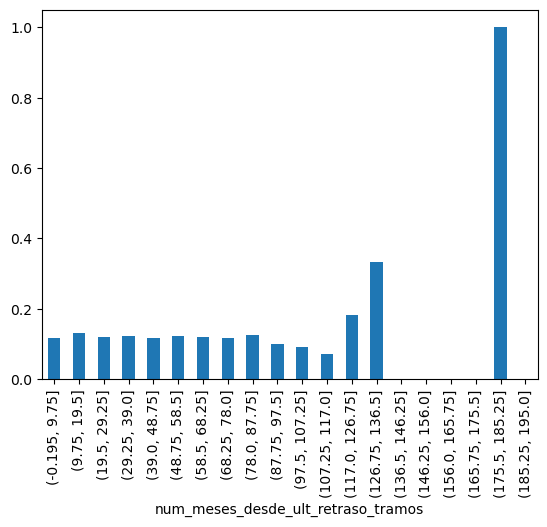

In [78]:
temp.groupby('num_meses_desde_ult_retraso_tramos').target.mean().plot.bar();

Hay una categoria donde el nivel de impago está al 100%, es decir todos los que tienen una antiguedad en cuanto al numero de meses desde que se produjo el retraso entre 175 y 185 han impagado todos.La distribución de la variable no nos genera demasiadas diferencias y si no hay diferencias, no hay capacidad predictiva,porque esta variable no nos va permitir dividir entre clientes con alta probabilidad de impago y baja probabilidad de impago.La eliminamos.

In [79]:
num.drop(columns='num_meses_desde_ult_retraso',inplace=True)

En vivienda juntar ANY, NONE y OTHER

In [80]:
cat.vivienda.value_counts()

MORTGAGE    68243
RENT        55153
OWN         15586
ANY            55
OTHER          14
NONE            2
Name: vivienda, dtype: int64

In [81]:
#Asignar a la categoria mayoritaria las categorias poco frecuentes
cat.vivienda = cat.vivienda.replace(['ANY','NONE','OTHER'],'MORTGAGE')

In [82]:
cat.vivienda.value_counts()

MORTGAGE    68314
RENT        55153
OWN         15586
Name: vivienda, dtype: int64

En finalidad juntar renewable_energy, educational y wedding en 'otros'

In [83]:
cat.finalidad.value_counts()

debt_consolidation    79055
credit_card           31309
home_improvement       9138
other                  8581
major_purchase         3149
medical                1694
small_business         1571
car                    1423
vacation               1011
moving                  955
house                   918
wedding                 142
renewable_energy         85
educational              22
Name: finalidad, dtype: int64

In [84]:
cat.finalidad = cat.finalidad.replace(['wedding','educational','renewable_energy'],'otros')

In [85]:
cat.finalidad.value_counts()

debt_consolidation    79055
credit_card           31309
home_improvement       9138
other                  8581
major_purchase         3149
medical                1694
small_business         1571
car                    1423
vacation               1011
moving                  955
house                   918
otros                   249
Name: finalidad, dtype: int64

## TRANSFORMACIÓN DE CATEGÓRICAS

### One Hot Encoding

#### Variables a aplicar OHE

In [86]:
cat

,empleo,antigüedad_empleo,ingresos_verificados,rating,vivienda,descripcion,finalidad,num_cuotas,target_pd
id_cliente,,,,,,,,,
137387967,Hvac technician,3 years,Source Verified,A,MORTGAGE,desconocido,debt_consolidation,36 months,0
132883631,Subsea Technician,7 years,Source Verified,B,MORTGAGE,desconocido,debt_consolidation,36 months,0
131289518,desconocido,10+ years,Source Verified,D,MORTGAGE,desconocido,home_improvement,60 months,0
77861711,Correctional officer,10+ years,Verified,C,MORTGAGE,desconocido,debt_consolidation,36 months,1
103448519,Web site administrator,10+ years,Not Verified,A,MORTGAGE,desconocido,credit_card,36 months,0
...,...,...,...,...,...,...,...,...,...
73222117,Executive Assistant,10+ years,Verified,B,RENT,desconocido,debt_consolidation,36 months,0
129396054,Field Manager,10+ years,Source Verified,D,OWN,desconocido,debt_consolidation,60 months,0
121031962,Owner & President,6 years,Verified,B,MORTGAGE,desconocido,other,36 months,0


In [87]:
var_ohe = [ 'ingresos_verificados', 'vivienda','finalidad','num_cuotas']

#### Instanciar

In [88]:
#handle_unknown a none,para que no rompa el modelo en producción al introducir nueva categoria
ohe = OneHotEncoder(sparse = False, handle_unknown='ignore')

#### Entrenar y aplicar

In [89]:
cat_ohe = ohe.fit_transform(cat[var_ohe])

C:\Users\Marius\miniconda3\envs\riskscoring\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### Guardar como dataframe

In [90]:
cat_ohe = pd.DataFrame(cat_ohe, columns = ohe.get_feature_names_out())

In [91]:
cat_ohe

,ingresos_verificados_Not Verified,ingresos_verificados_Source Verified,ingresos_verificados_Verified,vivienda_MORTGAGE,vivienda_OWN,vivienda_RENT,finalidad_car,finalidad_credit_card,finalidad_debt_consolidation,finalidad_home_improvement,finalidad_house,finalidad_major_purchase,finalidad_medical,finalidad_moving,finalidad_other,finalidad_otros,finalidad_small_business,finalidad_vacation,num_cuotas_ 36 months,num_cuotas_ 60 months
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139048,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
139049,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
139050,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
139051,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


### Ordinal Encoding

Las variables antigüedad_empleo y rating tienen un orden.

#### Variables a aplicar OE

In [92]:
var_oe = ['antigüedad_empleo','rating']

#### Orden de los valores de las variables

In [93]:
#Orden de la primera variable
orden_antigüedad_empleo = ['desconocido','< 1 year','1 year','2 years','3 years','4 years',
                           '5 years','6 years','7 years','8 years','9 years','10+ years']

#Orden de la segunda variable
#este orden lo ponemos asi debido a que lo que queremos predecir son los 1, es decir los clientes con PD
#previsiblemente los clientes que tienen un perfil A van a tener una menor PD, mientras que tengan la clase G
#tendra un mayor PD, por lo tanto a la hora de definir el orden hay que tener en cuenta esto para poder interpretarlo bien
orden_rating = ['A','B','C','D','E','F','G']

#### Instanciar

In [94]:
oe = OrdinalEncoder(categories = [orden_antigüedad_empleo,orden_rating],
                    handle_unknown = 'use_encoded_value',
                    unknown_value = 12)

#### Entrenar y aplicar

In [95]:
cat_oe = oe.fit_transform(cat[var_oe])

#### Guardar como dataframe

In [96]:
#Añadir sufijos a los nombres
nombres_oe = [variable + '_oe' for variable in var_oe]

#Guardar como dataframe
cat_oe = pd.DataFrame(cat_oe, columns = nombres_oe)

### Fechas y textos

Cargamos stopwords y limpiamos

In [97]:
#tener en cuenta el tipo de texto que estamos manejando para usar las stop_words adecuadas
stop = pd.read_csv(ruta_proyecto + '/01_Documentos/stop_words_english.txt',names = ['termino'])

def quitar_tildes(palabra):
    #Definimos la versión con tildes y símbolos y la sin
    con = 'áéíóúüñÁÉÍÓÚÜÑ'
    sin = 'aeiouunAEIOUUN'
    #Creamos un traductor
    traductor = str.maketrans(con,sin)
    #Aplicamos el traductor y devolvemos la palabra limpia
    return(palabra.translate(traductor))

stop['limpias'] = stop.termino.transform(quitar_tildes)

Aplicamos tf-idf.

In [98]:
#Instanciamos
tfidf = TfidfVectorizer(strip_accents = 'unicode',
                     stop_words = stop.limpias.to_list(),
                     max_df = 0.7,
                     min_df = 50, #que no considere ninguna palabra que se repita menos de 50 veces,para no incrementar la dimension de varialbes que tenemos que utilizar
                     ngram_range = (1,3),
                     max_features = 50) #max variables que queremos coger

#Entrenamos y aplicamos
descripcion = tfidf.fit_transform(cat.descripcion)

C:\Users\Marius\miniconda3\envs\riskscoring\Lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ain', 'al', 'couldn', 'daren', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'itse', 'll', 'mayn', 'mightn', 'mon', 'mustn', 'myse', 'needn', 'oughtn', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [39]:
#aqui hay que entender el beneficio que nos puede aportar esta variable a nuestra modelizacion y tambien el tiempo e computo
#esto lo hacemos probando,miramos a la fase de preseleccion, que importancia tienen estas variables
#o la otra manera esa ojo,revisando los terminos,aver si alguno nos puede aportar algun tipo de informacion
tfidf.vocabulary_

{'borrower': 15,
 '07': 6,
 '13': 12,
 'consolidate': 29,
 'credit': 31,
 'card': 26,
 'years': 49,
 'br': 22,
 'borrower 07': 20,
 'credit card': 32,
 '12': 11,
 'loan': 38,
 'time': 48,
 'cards': 28,
 'payment': 45,
 'pay': 42,
 'borrower 12': 21,
 'br br': 24,
 'br borrower': 23,
 'br br borrower': 25,
 'monthly': 41,
 '11': 10,
 '09': 8,
 'job': 37,
 '10': 9,
 '08': 7,
 'pay credit': 43,
 'credit cards': 34,
 '05': 4,
 '01': 0,
 'bills': 14,
 '03': 2,
 '14': 13,
 'paying': 44,
 'borrower 01': 16,
 'money': 39,
 '06': 5,
 'high': 36,
 'debt': 35,
 'payments': 46,
 '02': 1,
 'borrower 02': 17,
 '04': 3,
 'borrower 06': 19,
 'consolidation': 30,
 'month': 40,
 'borrower 03': 18,
 'rate': 47,
 'card debt': 27,
 'credit card debt': 33}

No parece que estos términos puedan generar información adicional a lo que tenemos, así que no incluiremos esta variable en los modelos, no la vamos a pasar ni a la fase de preseleccion ya que tenemos otras variables que nos aportan informacion mas relevante.

## TRANSFORMACIÓN DE NUMÉRICAS

En cuanto a Normlaizacion de Gauss no vamos a aplicar nada debido a que cuando vimos las graficas de densidad, vimos unas distribuciones bastante normales.

### Binarizar variables

#### Variables a binarizar

In [99]:
var_bin = ['num_derogatorios']

#### Instanciar

In [100]:
bin = Binarizer(threshold=0)

#### Entrenar y aplicar

In [101]:
num_bin = bin.fit_transform(num[var_bin])

#### Guardar como dataframe

In [102]:
#Añadir sufijos a los nombres
nombres_bin = [variable + '_bin' for variable in var_bin]

#Guardar como dataframe
num_bin = pd.DataFrame(num_bin,columns = nombres_bin)

## REESCALAR VARIABLES

### Con Min-Max

Debido a que tenemos bastantes variables con OHE, es mejor reescalar con Min-Max. Para hacerlo todo lo mas homogeneo posible.
Esta transformacion de MMS, se la vamos a aplicar, en cuanto a las variables categoricas a aquellas que ya le hemos aplicado una transformacion de ordinal encoding,porque a las de OHE no tiene sentido, ya nos va generar variables de 0 y 1 y en cuanto a las variables numericas vamos a reescalar todas con MMS, excepto la que vamos a binarizar ya que esa es 0 y 1, por lo tanto no hace falta.
Unificar los datasets a reescalar.


In [103]:
num_escalar = num[['ingresos',
                  'dti',
                  'num_lineas_credito',
                  'porc_uso_revolving',
                  'principal',
                  'tipo_interes',
                  'imp_cuota']].reset_index(drop=True)

In [104]:
#aqui reescalamos cn min max tambien las variables categoricas oe, por lo tanto las concatenamos con las numericas 
df_res = pd.concat([cat_oe,num_escalar], axis=1)

#### Variables a reescalar con Min-Max

In [105]:
var_mms = df_res.columns

#### Instanciar

In [106]:
mms = MinMaxScaler()

#### Entrenar y aplicar

In [ ]:
df_mms = mms.fit_transform(df_res[var_mms])

#### Guardar como dataframe

In [107]:
#Añadir sufijos a los nombres
nombres_mms = [variable + '_mms' for variable in var_mms]

#Guardar como dataframe
df_mms = pd.DataFrame(df_mms,columns = nombres_mms)

## UNIFICAR DATASETS

### Crear una lista con los dataframes y variables a incluir en el tablón analítico para el modelo de PD

In [108]:
incluir_pd = [cat_ohe, cat_oe, df_mms, num_bin, cat.reset_index()[['id_cliente','target_pd']]]

### Unir todos los dataframes en el tablón analítico para el modelo de PD

In [109]:
df_pd = pd.concat(incluir_pd, axis = 1)

In [110]:
df_pd.set_index('id_cliente',inplace=True)

### Crear una lista con los dataframes y variables a incluir en el tablón analítico para el modelo de EAD

In [111]:
incluir_ead = [cat_ohe, cat_oe, df_mms, num_bin, num.reset_index()[['id_cliente','target_ead']]]

### Unir todos los dataframes en el tablón analítico para el modelo de EAD

In [112]:
df_ead = pd.concat(incluir_ead, axis = 1)

In [ ]:
df_ead.set_index('id_cliente',inplace=True)

### Crear una lista con los dataframes y variables a incluir en el tablón analítico para el modelo de LGD

In [113]:
incluir_lgd = [cat_ohe, cat_oe, df_mms, num_bin, num.reset_index()[['id_cliente','target_lgd']]]

### Unir todos los dataframes en el tablón analítico para el modelo de LGD

In [114]:
df_lgd = pd.concat(incluir_lgd, axis = 1)

In [115]:
df_lgd.set_index('id_cliente',inplace=True)

## GUARDAR DATASETS TRAS TRANSFORMACIÓN DE DATOS

En formato pickle para no perder las modificaciones de metadatos.

In [116]:
#Definir los nombres de los archivos
ruta_df_tablon_pd = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'df_tablon_pd.pickle'
ruta_df_tablon_ead = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'df_tablon_ead.pickle'
ruta_df_tablon_lgd = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'df_tablon_lgd.pickle'

In [ ]:
#Guardar los archivos
df_pd.to_pickle(ruta_df_tablon_pd)
df_ead.to_pickle(ruta_df_tablon_ead)
df_lgd.to_pickle(ruta_df_tablon_lgd)